# Pipeline A-Predictor IA

Pipeline de preprocesamiento de datos, incluye:

* Procesador para limpieza de datos
* Transformador que implementa la limpieza de datos
* Identifica la velocidad nominal de operación para el bloque estable con mayor velocidad promedio
* Transformador para cortar los datos
* Transformador para escalar los datos y eliminar el ruido

In [ ]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from typing import Optional, Dict
import joblib

In [ ]:
class DataProcessor:
    def __init__(self, delimiter=";", date_format="%Y/%m/%d %H:%M:%S"):
        self.delimiter = delimiter
        self.date_format = date_format

    def read_file(self, file_path):
        """Reads a CSV file with a specified delimiter, skipping non-data header lines."""
        try:
            df = pd.read_csv(file_path, delimiter=self.delimiter, skiprows=2)
            return df
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
            return None

    def clean_and_reorder_columns(self, df):
        """Cleans columns by removing 'AXI' if it exists, reordering columns, and renaming them."""
        if "AXI" in df.columns:
            df = df.drop("AXI", axis=1)

        # Ensure 'Fecha' is the first column
        date_col = df.columns[0]
        other_cols = [col for col in df.columns if col != date_col]
        df = df[[date_col] + other_cols]

        # Rename columns to standardize
        df.columns = ["Fecha"] + [df.columns[i] for i in range(1, len(df.columns))]
        return df

    def convert_to_float_and_date_time(self, df):
        """Converts columns to the appropriate data types."""
        # Explicitly replace commas and convert to float for all numeric columns
        for col in df.columns[1:]:
            df[col] = df[col].astype(str).str.replace(",", ".").astype(float)
        df["Fecha"] = pd.to_datetime(
            df["Fecha"], format=self.date_format, errors="coerce"
        )
        return df

    def process_file(self, file_path):
        """Processes a single file by reading, cleaning, and converting data types."""
        df = self.read_file(file_path)
        if df is not None:
            df = self.clean_and_reorder_columns(df)
            df = self.convert_to_float_and_date_time(df)
        return df

In [ ]:
# Transformador para cargar datos
class DataLoader(BaseEstimator, TransformerMixin):
    def __init__(self, speed_col='KPH', date_col='Fecha', delimiter=";", date_format="%Y/%m/%d %H:%M:%S"):
        self.speed_col = speed_col
        self.date_col = date_col
        self.delimiter = delimiter
        self.date_format = date_format
        self.data_processor = DataProcessor(delimiter=delimiter, date_format=date_format)
        self.df_original = None  # Para guardar los datos originales

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        """Carga los datos desde una ruta de archivo o un DataFrame."""
        if isinstance(X, str):
            df = self.data_processor.process_file(X)
            if df is None:
                raise ValueError(f"No se pudo cargar el archivo: {X}")
        elif isinstance(X, pd.DataFrame):
            df = X.copy()
        else:
            raise ValueError("X debe ser una ruta de archivo (str) o un DataFrame.")

        self.df_original = df.copy()  # Guardar datos originales para visualización
        return df

    def get_original_data(self):
        """Devuelve los datos originales para visualización."""
        if self.df_original is None:
            raise ValueError("No se han cargado datos todavía.")
        return self.df_original

In [ ]:
# Transformador para identificar la velocidad nominal
class NominalSpeedIdentifier(BaseEstimator, TransformerMixin):
    def __init__(self, speed_col: str = 'KPH', max_speed_diff: float = 1.0,
                 min_stable_points: int = 10, top_n_blocks: int = 3) -> None:
        self.speed_col: str = speed_col
        self.max_speed_diff: float = max_speed_diff
        self.min_stable_points: int = min_stable_points
        self.top_n_blocks: int = top_n_blocks
        self.nominal_speed: Optional[float] = None
        self.max_values: Optional[Dict[str, float]] = None

    def fit(self, X: pd.DataFrame, y: None = None) -> "NominalSpeedIdentifier":
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        """Identifica la velocidad nominal y calcula los valores máximos de variables en bloques estables."""
        if not isinstance(X, pd.DataFrame):
            raise ValueError("X debe ser un DataFrame.")

        df: pd.DataFrame = X.copy()
        df['speed_diff'] = df[self.speed_col].diff().abs()
        df['is_stable'] = df['speed_diff'] < self.max_speed_diff
        df['stable_block'] = (df['is_stable'] != df['is_stable'].shift()).cumsum() * df['is_stable']
        stable_blocks: pd.Series = df[df['stable_block'] > 0].groupby('stable_block').size()

        if stable_blocks.empty or stable_blocks.max() < self.min_stable_points:
            raise ValueError("No se encontró una región estable suficientemente larga.")

        stable_blocks_sorted: pd.Series = stable_blocks[stable_blocks >= self.min_stable_points].sort_values(ascending=False)
        top_blocks: pd.Index = stable_blocks_sorted.head(min(self.top_n_blocks, len(stable_blocks_sorted))).index
        if not top_blocks.any():
            raise ValueError("No se encontraron bloques estables que cumplan con el mínimo de puntos.")

        # Seleccionar el bloque con mayor velocidad promedio
        block_means: pd.Series = df[df['stable_block'].isin(top_blocks)].groupby('stable_block')[self.speed_col].mean()
        selected_block: int = block_means.idxmax()
        stable_region: pd.DataFrame = df[df['stable_block'] == selected_block]
        self.nominal_speed = stable_region[self.speed_col].mean()

        # Calcular valores máximos de columnas (excepto speed_col y temporales) en top_blocks
        columns_to_analyze: list[str] = [
            col for col in df.columns
            if col not in [self.speed_col, 'speed_diff', 'is_stable', 'stable_block']
        ]
        stable_data: pd.DataFrame = df[df['stable_block'].isin(top_blocks)][columns_to_analyze]
        self.max_values = stable_data.max(numeric_only=True).to_dict()

        df.drop(columns=['speed_diff', 'is_stable', 'stable_block'], inplace=True)
        return df

    def get_nominal_speed(self) -> float:
        """Devuelve la velocidad nominal calculada."""
        if self.nominal_speed is None:
            raise ValueError("No se ha calculado la velocidad nominal todavía.")
        return self.nominal_speed

    def get_max_values(self) -> Dict[str, float]:
        """Devuelve los valores máximos de las variables en los bloques estables."""
        if self.max_values is None:
            raise ValueError("No se han calculado los valores máximos todavía.")
        return self.max_values

In [ ]:
# Transformador para cortar datos
class DataCutter(BaseEstimator, TransformerMixin):
    def __init__(self, speed_col='KPH', fall_threshold=0.95, min_consecutive=3):
        self.speed_col = speed_col
        self.fall_threshold = fall_threshold
        self.min_consecutive = min_consecutive
        self.nominal_speed = None

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        """Corta los datos desde el inicio de la caída de velocidad."""
        if not isinstance(X, pd.DataFrame):
            raise ValueError("X debe ser un DataFrame.")

        if self.nominal_speed is None:
            raise ValueError("La velocidad nominal debe estar definida (asegúrate de ejecutar NominalSpeedIdentifier primero).")

        df = X.copy()
        below_threshold = df[self.speed_col] < self.fall_threshold * self.nominal_speed
        for i in range(len(df) - self.min_consecutive + 1):
            if below_threshold.iloc[i]:
                if all(df[self.speed_col].iloc[i+j] < df[self.speed_col].iloc[i+j-1]
                       for j in range(1, self.min_consecutive)):
                    inicio_caida_idx = df.index[i]
                    return df.loc[inicio_caida_idx:].copy()
        return df.iloc[-1:].copy()

    def set_nominal_speed(self, nominal_speed):
        """Permite establecer la velocidad nominal desde el pipeline."""
        self.nominal_speed = nominal_speed
        return self

In [ ]:
# Transformador para escalar datos y eliminar ruido
class DataScaler(BaseEstimator, TransformerMixin):
    def __init__(self, speed_col='KPH', date_col='Fecha', method='standard', minmax_range=(0, 1),
                 include_speed=True, trim_percentage=0.0):
        self.speed_col = speed_col
        self.date_col = date_col
        self.method = method
        self.minmax_range = minmax_range
        self.include_speed = include_speed
        self.trim_percentage = trim_percentage
        self.scaler = None

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        """Escala las columnas y elimina ruido basado en la velocidad escalada."""
        if not isinstance(X, pd.DataFrame):
            raise ValueError("X debe ser un DataFrame.")

        df = X.copy()
        displacement_cols = [col for col in df.columns if col not in [self.date_col]]
        columns_to_scale = displacement_cols.copy()
        if self.include_speed and self.speed_col in df.columns:
            columns_to_scale.append(self.speed_col)

        for col in columns_to_scale:
            if col not in df.columns:
                raise ValueError(f"La columna {col} no está en el DataFrame.")

        if self.method == 'standard':
            self.scaler = StandardScaler()
        elif self.method == 'minmax':
            self.scaler = MinMaxScaler(feature_range=self.minmax_range)
        else:
            raise ValueError("El método debe ser 'standard' o 'minmax'.")

        df[columns_to_scale] = self.scaler.fit_transform(df[columns_to_scale])

        if self.trim_percentage > 0 and self.trim_percentage <= 1:
            if self.method == 'standard':
                speed_scaled_min = df[self.speed_col].min()
                threshold = speed_scaled_min + self.trim_percentage * (0 - speed_scaled_min)
            elif self.method == 'minmax':
                threshold = self.trim_percentage * self.minmax_range[1]
            df = df[df[self.speed_col] > threshold].copy()

        return df

In [ ]:
# Pipeline completo
class TurbineDataPipeline:
    def __init__(self, speed_col='KPH', date_col='Fecha', delimiter=";", date_format="%Y/%m/%d %H:%M:%S",
                 max_speed_diff=1.0, min_stable_points=10, top_n_blocks=3,
                 fall_threshold=0.95, min_consecutive=3,
                 scale_method='standard', minmax_range=(0, 1), include_speed=True, trim_percentage=0.0):
        """Inicializa el pipeline de preprocesamiento para datos de turbinas."""
        self.speed_col = speed_col
        self.date_col = date_col
        self.pipeline = Pipeline([
            ('loader', DataLoader(speed_col=speed_col, date_col=date_col, delimiter=delimiter, date_format=date_format)),
            ('nominal_speed', NominalSpeedIdentifier(speed_col=speed_col, max_speed_diff=max_speed_diff,
                                                    min_stable_points=min_stable_points, top_n_blocks=top_n_blocks)),
            ('cutter', DataCutter(speed_col=speed_col, fall_threshold=fall_threshold, min_consecutive=min_consecutive)),
            ('scaler', DataScaler(speed_col=speed_col, date_col=date_col, method=scale_method,
                                 minmax_range=minmax_range, include_speed=include_speed, trim_percentage=trim_percentage))
        ])

    def fit_transform(self, X):
        """Procesa los datos y devuelve el DataFrame preprocesado y la velocidad nominal."""
        # Paso 1: Cargar los datos
        df = self.pipeline.named_steps['loader'].fit_transform(X)

        # Paso 2: Identificar la velocidad nominal
        df = self.pipeline.named_steps['nominal_speed'].fit_transform(df)
        nominal_speed = self.pipeline.named_steps['nominal_speed'].get_nominal_speed()
        max_values = self.pipeline.named_steps['nominal_speed'].get_max_values()

        # Paso 3: Pasar la velocidad nominal al cutter
        self.pipeline.named_steps['cutter'].set_nominal_speed(nominal_speed)

        # Paso 4: Cortar los datos
        df = self.pipeline.named_steps['cutter'].fit_transform(df)

        # Paso 5: Escalar los datos y eliminar ruido
        df_processed = self.pipeline.named_steps['scaler'].fit_transform(df)

        return df_processed, nominal_speed, max_values

    def get_original_data(self):
        """Devuelve los datos originales para visualización."""
        return self.pipeline.named_steps['loader'].get_original_data()

    def save(self, filepath):
        """Guarda el pipeline en un archivo para usarlo en el frontend."""
        joblib.dump(self, filepath)
        print(f"Pipeline guardado en {filepath}")

    @staticmethod
    def load(filepath):
        """Carga un pipeline guardado desde un archivo."""
        pipeline = joblib.load(filepath)
        print(f"Pipeline cargado desde {filepath}")
        return pipeline

### Ejemplo

In [ ]:
pipeline = TurbineDataPipeline(
        speed_col='KPH',
        date_col='Fecha',
        max_speed_diff=1.0,
        min_stable_points=10,
        top_n_blocks=5,
        fall_threshold=0.95,
        min_consecutive=20,
        scale_method='minmax',
        trim_percentage=0.1
    )

In [ ]:
file_path = '/content/drive/MyDrive/tests/unprocessed/Histórico, Tendencia_ UNIDAD 1 (1).csv'

In [ ]:
file_path = '/content/Histórico, Tendencia_ UNIDAD 1 MUNICIPAL.csv'

In [ ]:
df_processed, nominal_speed, max_values = pipeline.fit_transform(file_path)

Los bloque estables son: stable_block
14    3320
24    1398
36     131
2      118
dtype: int64
Los bloque top son: Index([14, 24, 36, 2], dtype='int64', name='stable_block')
Los bloques con mayor velocidad promedio son: stable_block
2       0.000000
14    357.256078
24    122.099091
36      0.000000
Name: KPH, dtype: float64
La región estable con mayor velocidad promedio es:                    Fecha         KPH         CTLX         CTLY        CGAX  \
221  2025-01-16 10:35:24  256.370313   934.796596   875.416918  222.281590   
222  2025-01-16 10:35:25  257.286432   937.510098   874.771731  220.660839   
223  2025-01-16 10:35:26  258.238063   941.983878   878.715910  223.037877   
224  2025-01-16 10:35:27  259.225923   940.475477   881.357855  222.786414   
225  2025-01-16 10:35:28  260.045147   936.274047   882.863607  224.166615   
...                  ...         ...          ...          ...         ...   
3536 2025-01-16 11:30:39  379.146919  1258.297606  1198.009826  194.474981  

In [ ]:
df_original = pipeline.get_original_data()
print("Datos originales:")
print(df_original.head())
print("\nDatos preprocesados:")
print(df_processed.head())
print(f"\nVelocidad nominal: {nominal_speed}")
print(f"\nValores máximos en bloques estables: {max_values}")

Datos originales:
                Fecha  KPH      CTLX      CTLY      CGAX      CGAY      CTAX  \
0 2025-01-16 10:31:43  0.0  0.365673  0.360071  0.409458  0.440391  0.373291   
1 2025-01-16 10:31:44  0.0  0.338057  0.399447  0.451685  0.378498  0.358055   
2 2025-01-16 10:31:45  0.0  0.389004  0.356750  0.433181  0.357074  0.367102   
3 2025-01-16 10:31:46  0.0  0.354246  0.341569  0.406611  0.384211  0.380434   
4 2025-01-16 10:31:47  0.0  0.334724  0.330658  0.409458  0.398018  0.389004   

       CTAY  
0  0.323824  
1  0.311443  
2  0.301442  
3  0.323348  
4  0.308109  

Datos preprocesados:
                   Fecha       KPH      CTLX      CTLY      CGAX      CGAY  \
3579 2025-01-16 11:31:22  1.000000  0.996572  0.991386  0.874949  0.919544   
3580 2025-01-16 11:31:23  0.997510  1.000000  0.993589  0.879125  0.920792   
3581 2025-01-16 11:31:24  0.994902  0.995228  0.989138  0.878460  0.919284   
3582 2025-01-16 11:31:25  0.992198  0.990002  0.982314  0.880860  0.920669   
3583 

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
def plot_data(df):
    """
    Función para graficar las variables de desplazamiento (cualquiera que no sea Fecha y KPH)
    en el eje izquierdo y velocidad (KPH) en el eje derecho vs tiempo.
    """
    fig, ax1 = plt.subplots(figsize=(14, 8))  # Gráfica más grande

    # Eje 1: Desplazamientos (columnas dinámicas)
    # Format x-axis to show date and time
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))

    # Reduce the number of ticks
    ax1.xaxis.set_major_locator(ticker.MaxNLocator(10))
    plt.xticks(rotation=45, ha='right')
    ax1.set_xlabel('Fecha', fontsize=10)
    ax1.set_ylabel('Desplazamientos (um pk-pk)', color='tab:red', fontsize=10)

    # Get columns to plot (excluding 'Fecha' and 'KPH')
    columns_to_plot = [col for col in df.columns if col not in ['Fecha', 'KPH']]

    # Define a list of colors for the plots
    colors = ['tab:red', 'tab:green', 'tab:orange', 'tab:gray', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:olive', 'tab:cyan']

    # Iterate and plot each column
    for i, column in enumerate(columns_to_plot):
        ax1.plot(df['Fecha'], df[column], color=colors[i % len(colors)], label=column)  # Cycle through colors

    ax1.tick_params(axis='y', labelcolor='tab:red', labelsize=8)

    # Improved grid: lighter color, dashed lines
    ax1.grid(True, linestyle='--', linewidth=0.5, color='lightgray')

    # Eje 2: Velocidad (KPH)
    ax2 = ax1.twinx()  # Eje derecho que comparte el eje x
    ax2.set_ylabel('Velocidad (KPH)', color='tab:blue', fontsize=10)
    # Changed 'kph' to 'KPH' to match the actual column name
    ax2.plot(df['Fecha'], df['KPH'], color='tab:blue', label='Velocidad (KPH)')
    ax2.tick_params(axis='y', labelcolor='tab:blue', labelsize=8)

    # Añadimos leyenda en el costado derecho
    fig.legend(loc="upper left", bbox_to_anchor=(1.07, 0.75), fontsize=9)

    # Título dinámico basado en nombre del DataFrame y columnas
    # title = f"Gráfico de sensores de desplazamiento {columns_to_plot} del eje respecto a un punto de referencia y Velocidad (KPH) Normalizadas de una Turbina Hidráulica vs Tiempo (En el instante de parada)"
    # plt.title(title, fontsize=14, fontweight='bold', pad=15, wrap=True)

    # Ajustamos el formato de la gráfica
    fig.tight_layout()

    # Mostramos la gráfica
    plt.show()

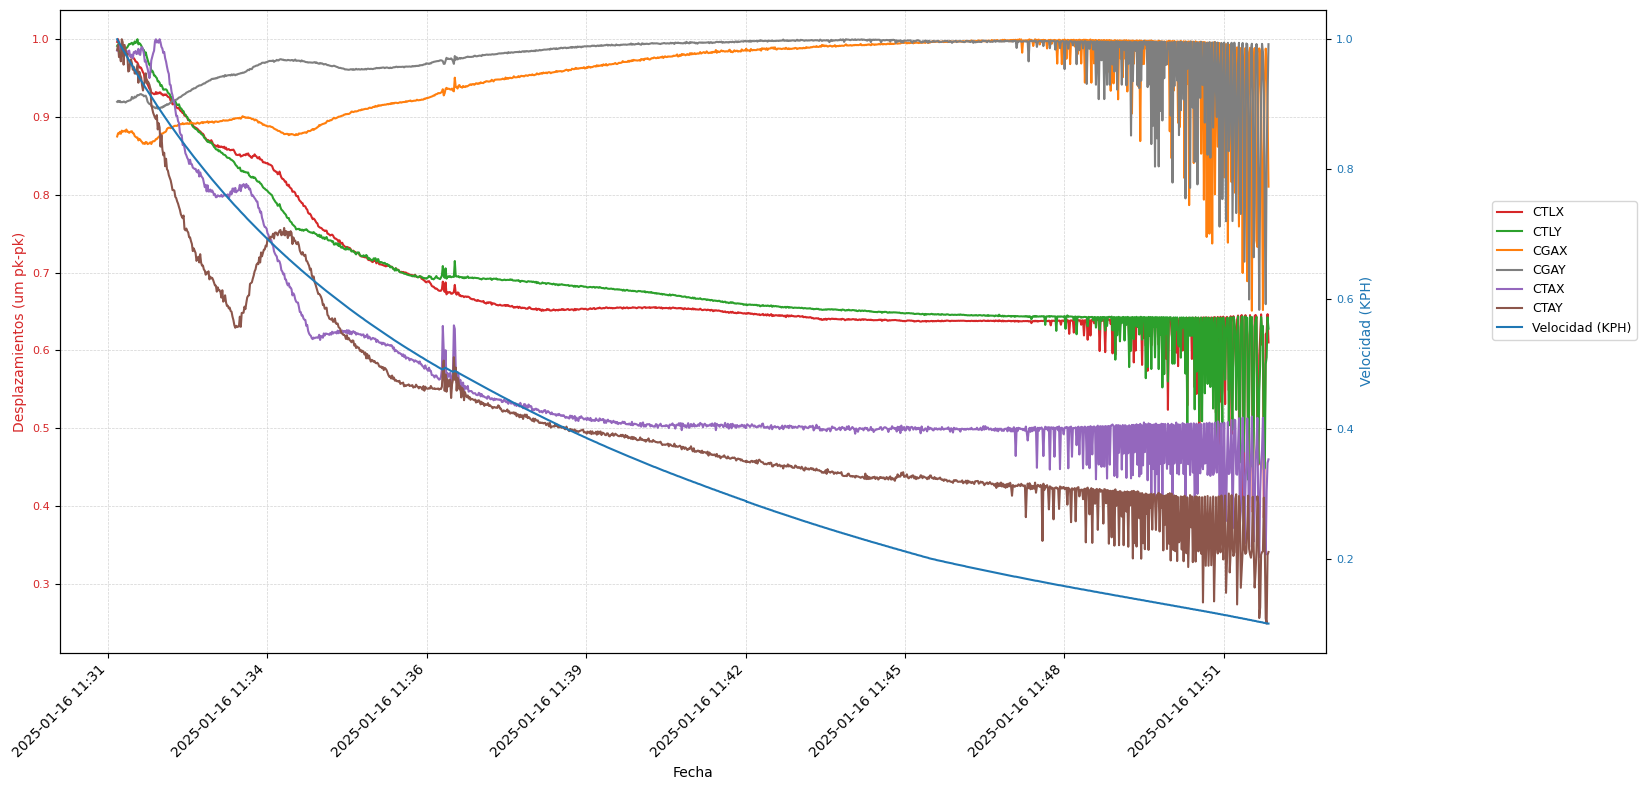

In [ ]:
plot_data(df_processed)

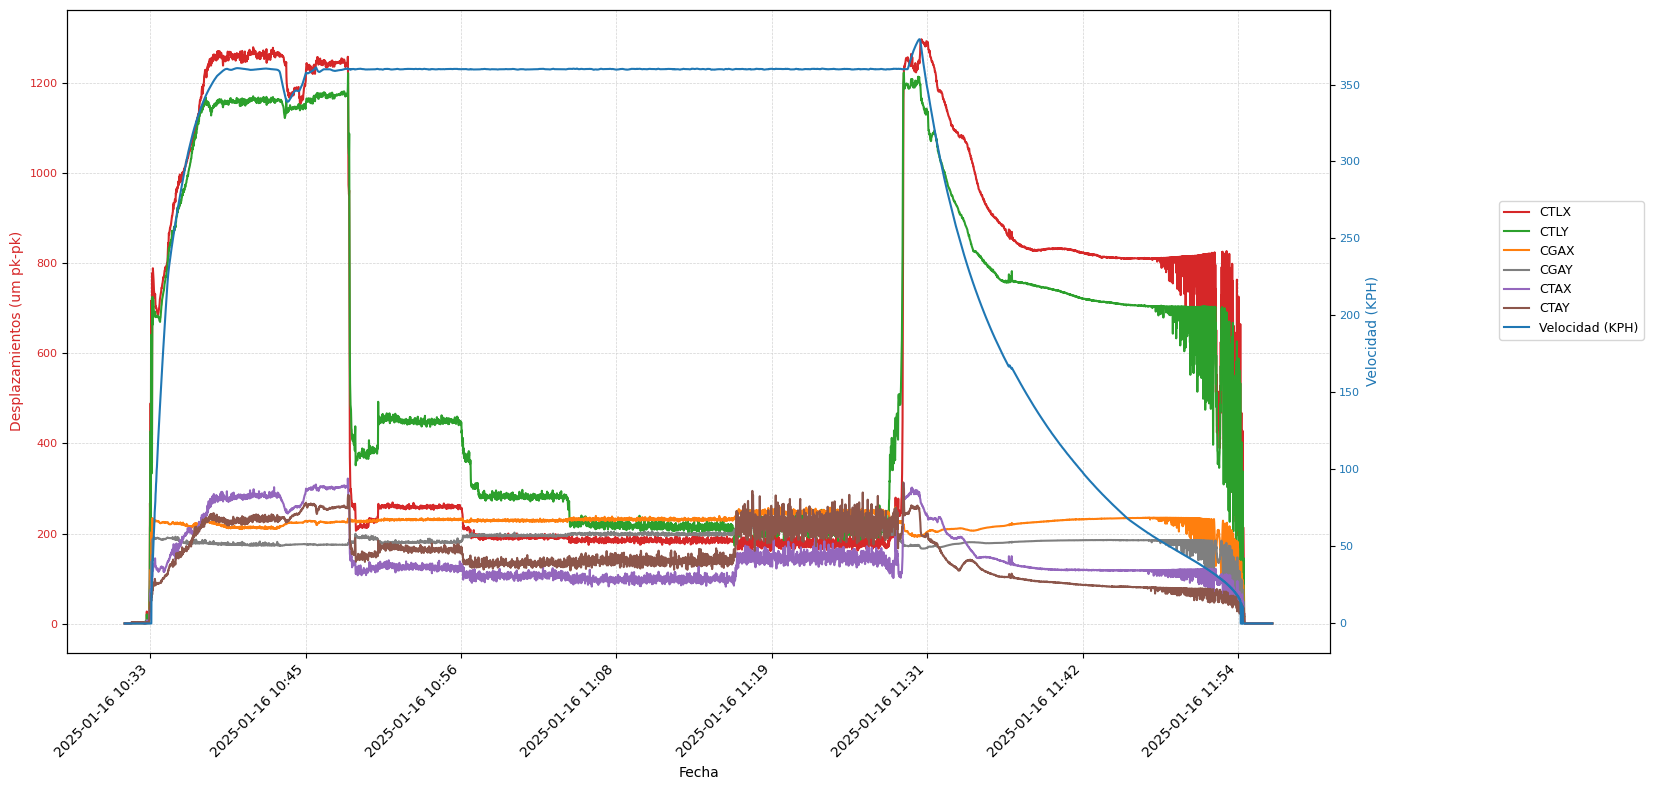

In [ ]:
plot_data(df_original)

In [ ]:
# Guardar el pipeline para usarlo en el frontend
pipeline.save("turbine_pipeline.joblib")